In [1]:
import os
import sys


# Define the base path
base_path = './tibo1/project/Lab3/'
# Set the working directory to the project root
#os.chdir('./tibo1/project/Lab3/')

# Convert to absolute path and add to sys.path
sys.path.append(os.path.abspath(base_path))

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as T
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import os
from model import UNet
from utils import get_device
import multiprocessing
from dataset import MyDataset
import random
from matplotlib import pyplot as plt
from augment import RandomErasing

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
preprocessed_expert_data = np.load('./out/preprocessed6bis/preprocessed_expert_data.npy', allow_pickle=True)
#expert_total_frames = np.load('./out/preprocessed6bis/expert_total_frames.npy')
preprocessed_amateur_data = np.load('./out/preprocessed6bis/preprocessed_amateur_data.npy', allow_pickle=True)
#amateur_total_frames = np.load('./out/preprocessed6bis/amateur_total_frames.npy')
preprocessed_test_data = np.load('./out/preprocessed6bis/preprocessed_test_data.npy', allow_pickle=True)

# Example Usage
device = get_device().type
use_amp = device == 'cuda'  # Use AMP only if on CUDA
BATCH_SIZE = 16

19

In [19]:
def train_model(X, Y, model, opti, loss_fn, trans, batch_size, n_epochs, patience,checkpoint_dir='./out/predict_boxes/checkpoints'):
    num_workers = multiprocessing.cpu_count()
    X0, X1, Y0, Y1 = train_test_split(X, Y,test_size=0.2)  # split over videos
    X0, X1, Y0, Y1 = map(np.concatenate, (X0, X1, Y0, Y1))

    train_loader = DataLoader(MyDataset(X0, Y0, trans), batch_size, shuffle=True, num_workers=num_workers,
                              pin_memory=True)
    val_loader = DataLoader(MyDataset(X1, Y1), batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    best_loss, counter = float("inf"), 0
    for epoch in range(n_epochs):
        train_loss = 0
        for x, y in tqdm.tqdm(train_loader, f"epoch {epoch + 1}/{n_epochs}"):
            pred = model(x.to(device))
            loss = loss_fn(pred, y.to(device))
            opti.zero_grad()
            loss.backward()
            opti.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        valid_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                valid_loss += loss_fn(model(x.to(device)), y.to(device)).item()
        valid_loss /= len(val_loader)
        print(f"train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}")
        
        
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'checkpoint_epoch{epoch}.pth'))
        torch.save(opti.state_dict(), os.path.join(checkpoint_dir, f'optimizer_epoch{epoch}.pth'))

        if valid_loss < best_loss:
            best_loss = valid_loss
            counter = 0
            best_model_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss {best_loss:.4f} at epoch {epoch}")
        else:
            counter += 1
            if counter >= patience:
                print(f"early stopping at epoch {epoch + 1}")
                break


In [20]:
def train_boxes(train_expert, train_amateur=None):
    model = UNet(n_classes=1, n_channels=1, bilinear=False)
    model = model.to(device)
    opti = optim.Adam(model.parameters())
    loss_fn = nn.BCEWithLogitsLoss()
    trans = T.Compose(
        [
            RandomErasing(scale=(0.1, 0.2)),
            T.RandomAffine(
                degrees=(-15, 15),
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                shear=(-15, 15),
                interpolation=T.InterpolationMode.BILINEAR,
            ),
            T.RandomPerspective(),
        ]
    )

    try:
        model.load_state_dict(torch.load("models/final_boxes_aligned_new.pth", weights_only=True))
    except:
        Xa, Ya, Xe, Ye = [], [], [], []

        if train_amateur is not None:
            
            for data in train_amateur:
                Xa.append(data["video"][::5])  # get every 5 frames
                Ya.append(np.repeat(data["box"][np.newaxis], len(Xa[-1]), axis=0))
                
            train_model(Xa, Ya, model, opti, loss_fn, trans, BATCH_SIZE, 100, 3)
            
        for data in train_expert:
            Xe.append(data["video"])
            Ye.append(np.repeat(data["box"][np.newaxis], len(Xe[-1]), axis=0))
            
        train_model(Xe, Ye, model, opti, loss_fn, trans, BATCH_SIZE, 100, 3)
        
        
            
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/final_boxes_aligned_new.pth")

In [22]:
train_boxes(train_expert=preprocessed_expert_data, train_amateur=preprocessed_amateur_data)

epoch 1/100: 100%|██████████| 80/80 [00:13<00:00,  5.77it/s]


train_loss: 0.8469, valid_loss: 0.7774
Best model saved with validation loss 0.7774 at epoch 0


epoch 2/100: 100%|██████████| 80/80 [00:13<00:00,  5.83it/s]


train_loss: 0.7368, valid_loss: 0.7058
Best model saved with validation loss 0.7058 at epoch 1


epoch 3/100: 100%|██████████| 80/80 [00:14<00:00,  5.69it/s]


train_loss: 0.6951, valid_loss: 0.6906
Best model saved with validation loss 0.6906 at epoch 2


epoch 4/100: 100%|██████████| 80/80 [00:13<00:00,  5.79it/s]


train_loss: 0.6838, valid_loss: 0.6796
Best model saved with validation loss 0.6796 at epoch 3


epoch 5/100: 100%|██████████| 80/80 [00:14<00:00,  5.67it/s]


train_loss: 0.6800, valid_loss: 0.6852


epoch 6/100: 100%|██████████| 80/80 [00:14<00:00,  5.69it/s]


train_loss: 0.6778, valid_loss: 0.6781
Best model saved with validation loss 0.6781 at epoch 5


epoch 7/100: 100%|██████████| 80/80 [00:13<00:00,  5.74it/s]


train_loss: 0.6761, valid_loss: 0.6754
Best model saved with validation loss 0.6754 at epoch 6


epoch 8/100: 100%|██████████| 80/80 [00:14<00:00,  5.71it/s]


train_loss: 0.6747, valid_loss: 0.6778


epoch 9/100: 100%|██████████| 80/80 [00:13<00:00,  5.75it/s]


train_loss: 0.6746, valid_loss: 0.6751
Best model saved with validation loss 0.6751 at epoch 8


epoch 10/100: 100%|██████████| 80/80 [00:14<00:00,  5.68it/s]


train_loss: 0.6741, valid_loss: 0.6754


epoch 11/100: 100%|██████████| 80/80 [00:14<00:00,  5.64it/s]


train_loss: 0.6727, valid_loss: 0.6762


epoch 12/100: 100%|██████████| 80/80 [00:15<00:00,  5.29it/s]


train_loss: 0.6730, valid_loss: 0.6744
Best model saved with validation loss 0.6744 at epoch 11


epoch 13/100: 100%|██████████| 80/80 [00:13<00:00,  5.73it/s]


train_loss: 0.6717, valid_loss: 0.6773


epoch 14/100: 100%|██████████| 80/80 [00:14<00:00,  5.64it/s]


train_loss: 0.6720, valid_loss: 0.6743
Best model saved with validation loss 0.6743 at epoch 13


epoch 15/100: 100%|██████████| 80/80 [00:14<00:00,  5.71it/s]


train_loss: 0.6718, valid_loss: 0.6741
Best model saved with validation loss 0.6741 at epoch 14


epoch 16/100: 100%|██████████| 80/80 [00:14<00:00,  5.66it/s]


train_loss: 0.6713, valid_loss: 0.6747


epoch 17/100: 100%|██████████| 80/80 [00:14<00:00,  5.71it/s]


train_loss: 0.6708, valid_loss: 0.6717
Best model saved with validation loss 0.6717 at epoch 16


epoch 18/100: 100%|██████████| 80/80 [00:13<00:00,  5.72it/s]


train_loss: 0.6712, valid_loss: 0.6753


epoch 19/100: 100%|██████████| 80/80 [00:13<00:00,  5.78it/s]


train_loss: 0.6701, valid_loss: 0.6720


epoch 20/100: 100%|██████████| 80/80 [00:13<00:00,  5.76it/s]


train_loss: 0.6702, valid_loss: 0.6729
early stopping at epoch 20


epoch 1/100: 100%|██████████| 82/82 [00:15<00:00,  5.18it/s]


train_loss: 0.6967, valid_loss: 0.6961
Best model saved with validation loss 0.6961 at epoch 0


epoch 2/100: 100%|██████████| 82/82 [00:14<00:00,  5.62it/s]


train_loss: 0.6924, valid_loss: 0.6894
Best model saved with validation loss 0.6894 at epoch 1


epoch 3/100: 100%|██████████| 82/82 [00:14<00:00,  5.76it/s]


train_loss: 0.6887, valid_loss: 0.6887
Best model saved with validation loss 0.6887 at epoch 2


epoch 4/100: 100%|██████████| 82/82 [00:14<00:00,  5.71it/s]


train_loss: 0.6871, valid_loss: 0.6872
Best model saved with validation loss 0.6872 at epoch 3


epoch 5/100: 100%|██████████| 82/82 [00:14<00:00,  5.71it/s]


train_loss: 0.6865, valid_loss: 0.6877


epoch 6/100: 100%|██████████| 82/82 [00:14<00:00,  5.73it/s]


train_loss: 0.6858, valid_loss: 0.6891


epoch 7/100: 100%|██████████| 82/82 [00:14<00:00,  5.77it/s]


train_loss: 0.6852, valid_loss: 0.6883
early stopping at epoch 7


### Inference on Training Expert Set

In [23]:
# Run inference on the train data
def predict_boxes_inference_only(data):
    size = 224
    model = UNet(n_classes=1, n_channels=1, bilinear=False).to(device)

    # Load the trained model
    model.load_state_dict(torch.load("models/final_boxes_aligned_new.pth", weights_only=True))
    model.eval()

    raw_boxes = []
    with torch.no_grad():
        for data in tqdm.tqdm(data, desc="Inference on Train Data"):
            video = torch.from_numpy(data['video']).float()  # Shape: (frames, height, width)
            video = video.unsqueeze(1)  # Add channel dimension. Shape: (frames, 1, height, width)

            # Split into batches for inference
            video_batches = torch.split(video, 64)
            Y = [model(batch.to(device)) for batch in video_batches]
            raw_boxes.append(torch.cat(Y, dim=0))

    boxes = []
    for raw_box in raw_boxes:
        # Ensure raw_box is 2D
        if raw_box.ndim > 2:
            raw_box = raw_box.mean(axis=0)  # Reduce extra dimensions

        # Convert to NumPy array
        raw_box_np = raw_box.cpu().numpy()

        # Ensure raw_box_np is 2D
        if raw_box_np.ndim > 2:
            #print(f"Reducing dimensions from {raw_box_np.shape} to 2D.")
            raw_box_np = raw_box_np.squeeze()  # Remove extra dimensions

        # Find coordinates of non-zero elements
        coords = np.argwhere(raw_box_np > 0.3)

        # Check if coords is empty
        if coords.size == 0:
            print("Warning: No values above threshold in raw_box. Skipping.")
            boxes.append(np.zeros_like(raw_box_np, dtype=bool))
            continue

        # Extract y and x coordinates
        y, x = coords[:, 0], coords[:, 1]  # Explicitly handle 2D coordinates

        # Create binary mask
        box = np.zeros(raw_box_np.shape, dtype=bool)


        box[y.min(): y.max() + 1, x.min(): x.max() + 1] = True
        boxes.append(box)

    return boxes

### Vizualize the results

In [24]:
# Plot the video frames where masks exist
def plot_train_inference_results_with_masks(data, num_videos=10):
    fig, axes = plt.subplots(num_videos, 3, figsize=(15, 5 * num_videos))

    for i in range(num_videos):
        # Get a frame index where a mask exists
        mask_indices = data[i]['frames']  # Indices where masks exist
        idx = random.choice(mask_indices)  # Randomly pick one valid frame index

        # Extract relevant data
        video_frame = data[i]['video'][idx]
        official_box = data[i]['box']  # Ground-truth box
        guessed_box = data[i]['guessed_box']  # Predicted box
        label_mask = data[i]['label'][idx]  # Ground-truth label/mask

        # Plot Original Frame
        axes[i, 0].imshow(video_frame, cmap='gray')
        axes[i, 0].set_title(f"Video Frame {idx}")
        axes[i, 0].axis('off')

        # Plot Frame with Official Box and Mask Overlay
        axes[i, 1].imshow(video_frame, cmap='gray')
        axes[i, 1].imshow(official_box, cmap='jet', alpha=0.5)
        axes[i, 1].imshow(label_mask, cmap='viridis', alpha=0.3)
        axes[i, 1].set_title(f"Frame + Official Box + Mask {idx}")
        axes[i, 1].axis('off')

        # Plot Frame with Guessed Box and Mask Overlay
        axes[i, 2].imshow(video_frame, cmap='gray')
        axes[i, 2].imshow(guessed_box, cmap='hot', alpha=0.5)
        axes[i, 2].imshow(label_mask, cmap='viridis', alpha=0.3)
        axes[i, 2].set_title(f"Frame + Guessed Box + Mask {idx}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot test video frames with guessed boxes
def plot_test_inference_results(data, num_videos=10):
    fig, axes = plt.subplots(num_videos, 2, figsize=(12, 3 * num_videos))  # 2 columns

    for i in range(num_videos):
        # Randomly select a video and frame
        video_idx = random.randint(0, len(data) - 1)
        video_data = data[video_idx]

        # Randomly pick a frame from the video
        frame_idx = random.randint(0, video_data['video'].shape[0] - 1)

        # Extract video frame and guessed box
        video_frame = video_data['video'][frame_idx]
        guessed_box = video_data['guessed_box']

        # Plot Original Frame (Column 1)
        axes[i, 0].imshow(video_frame, cmap='gray')
        axes[i, 0].set_title(f"Video {video_idx}, Frame {frame_idx}")
        axes[i, 0].axis('off')

        # Plot Frame with Guessed Box (Column 2)
        axes[i, 1].imshow(video_frame, cmap='gray')
        axes[i, 1].imshow(guessed_box, cmap='hot', alpha=0.5)  # Overlay guessed box
        axes[i, 1].set_title("Guessed Box")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

Inference on Train Data: 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]


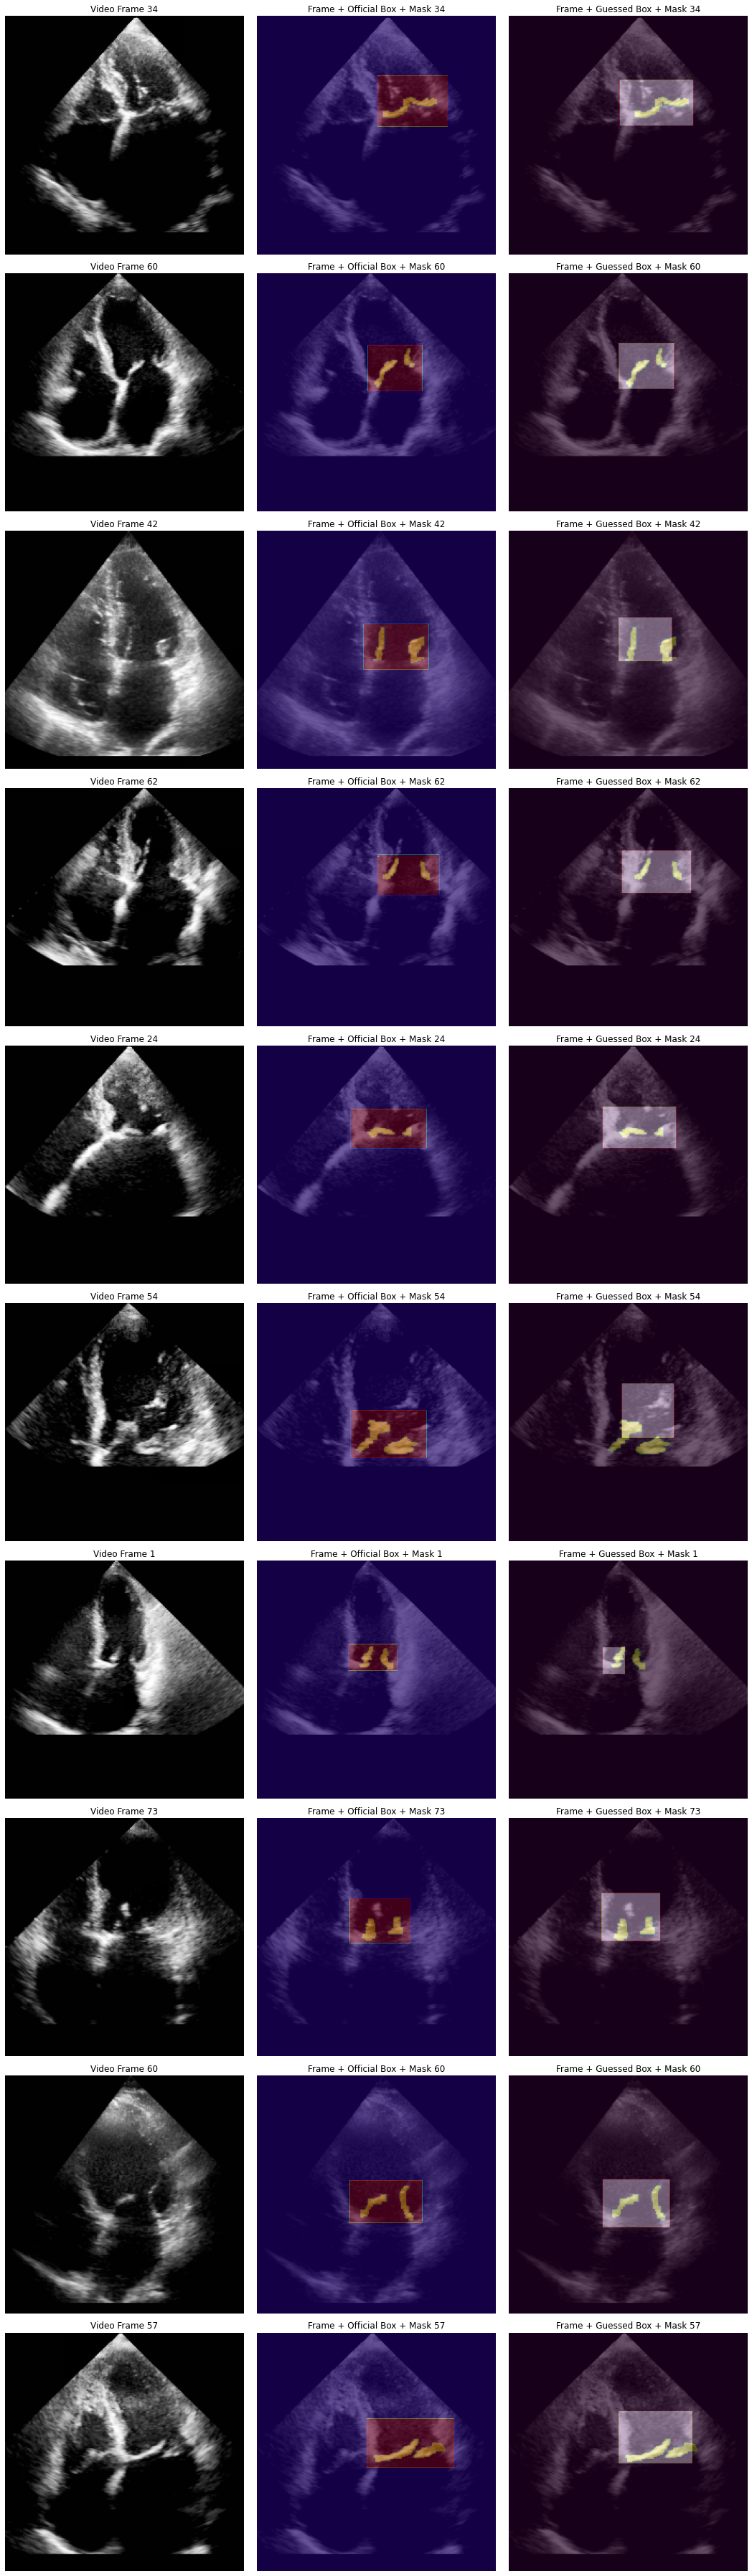

In [25]:
# Perform inference on the train data
train_boxes = predict_boxes_inference_only(preprocessed_expert_data)
for data, box in zip(preprocessed_expert_data, train_boxes):
    data['guessed_box'] = box

plot_train_inference_results_with_masks(preprocessed_expert_data, num_videos=10)

Inference on Train Data: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


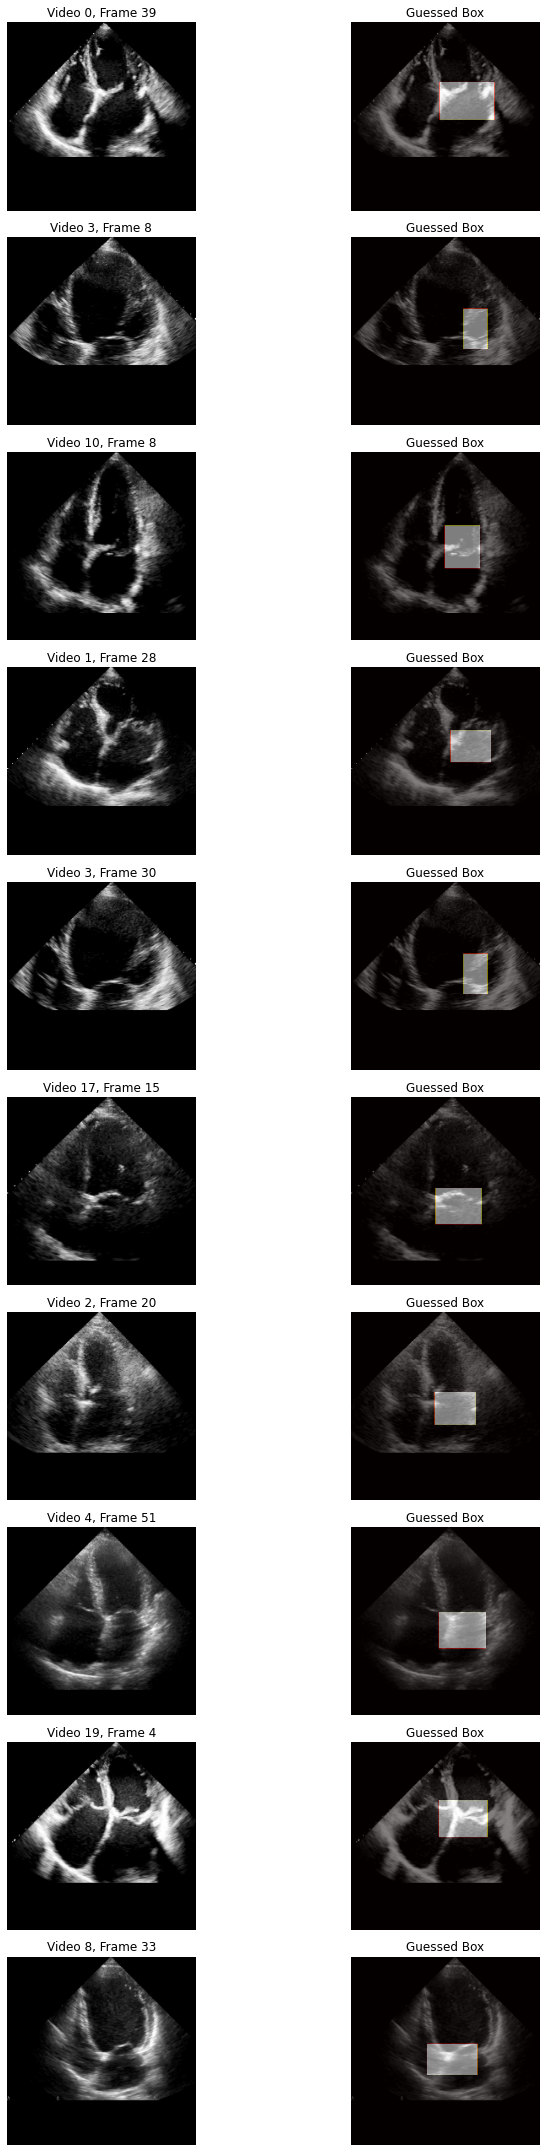

In [26]:
# Perform inference on the test data
test_boxes = predict_boxes_inference_only(preprocessed_test_data)
for data, box in zip(preprocessed_test_data, test_boxes):
    data['guessed_box'] = box

plot_test_inference_results(preprocessed_test_data, num_videos=10)

### Extract only Annotated frames (frame with non-zero masks)

In [27]:
for data in preprocessed_expert_data:
    frames = data['frames']  # Indices where masks exist

    video = data['video']
    label = data['label']
    # Subset the video and label arrays
    data['video'] = [video[i] for i in frames]
    data['label'] = [label[i] for i in frames]

for data in preprocessed_amateur_data:
    frames = data['frames']  # Indices where masks exist

    video = data['video']
    label = data['label']
    # Subset the video and label arrays
    data['video'] = [video[i] for i in frames]
    data['label'] = [label[i] for i in frames]

In [28]:
np.save('./out/preprocessed6bis/expert_train_annotated_frames.npy', preprocessed_expert_data)
np.save('./out/preprocessed6bis/amateur_train_annotated_frames.npy', preprocessed_amateur_data)
np.save('./out/preprocessed6bis/test_processed_with_boxes.npy', preprocessed_test_data)